In [1]:
import numpy as np
import pandas as pd
import numpy.random as rgt
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import scipy.stats as spstat
import time
from conquer.linear import high_dim

import multiprocessing
print('Number of CPUs:', multiprocessing.cpu_count())
rgt.seed(42)

def cov_generate(std, corr=0.5):
    p = len(std)
    R = np.zeros(shape=[p,p])
    for j in range(p-1):
        R[j, j+1:] = np.array(range(1, len(R[j,j+1:])+1))
    R += R.T
    return np.outer(std, std)*(corr*np.ones(shape=[p,p]))**R

Number of CPUs: 28


### Model selection and post-selection inference via bootstrap for high-dimensional quantile regression

In [2]:
n = 256
p = 1028
s = 8
tau = 0.8
 
Mu, Sig = np.zeros(p), cov_generate(rgt.uniform(1,2,size=p))
beta = np.zeros(p)
beta[:21] = [1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, -1, 0, 0, -1, 0, 0, -1]
true_set = np.where(beta!=0)[0]
print('true model:', true_set+1)

def boot_sim(m, itcp=True, parallel=False, ncore=0):
    rgt.seed(m)
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = 4 + X@beta + rgt.standard_t(2,n) - spstat.t.ppf(tau, df=2)
    
    sqr = high_dim(X, Y, intercept=itcp)
    lambda_sim = 0.75*np.quantile(sqr.self_tuning(tau), 0.9)

    boot_model = sqr.boot_inference(tau=tau, Lambda=lambda_sim, weight="Multinomial",
                                    parallel=parallel, ncore=ncore)
    
    per_ci = boot_model['percentile_ci']
    piv_ci = boot_model['pivotal_ci']
    norm_ci = boot_model['normal_ci']
    
    est_set = np.where(boot_model['boot_beta'][itcp:,0]!=0)[0]
    mb_set = boot_model['majority_vote']
    tp =  len(np.intersect1d(true_set, est_set))
    fp  = len(np.setdiff1d(est_set, true_set))
    mb_tp = len(np.intersect1d(true_set, mb_set))
    mb_fp = len(np.setdiff1d(mb_set, true_set))
    
    ci_cover = np.c_[(beta>=per_ci[1:,0])*(beta<=per_ci[1:,1]), 
                     (beta>=piv_ci[1:,0])*(beta<=piv_ci[1:,1]),
                     (beta>=norm_ci[1:,0])*(beta<=norm_ci[1:,1])]
    ci_width = np.c_[per_ci[1:,1] - per_ci[1:,0],
                     piv_ci[1:,1] - piv_ci[1:,0],
                     norm_ci[1:,1] - norm_ci[1:,0]]            
    return {'tp': tp, 'fp': fp, 'mb_tp': mb_tp, 'mb_fp': mb_fp, 
            'ci_cover': ci_cover, 'ci_width': ci_width}

true model: [ 1  3  6  9 12 15 18 21]


In [3]:
ci_cover, ci_width = np.zeros([p, 3]), np.zeros([p, 3])
M = 200
# true and false positives
tp, fp = np.zeros(M), np.zeros(M)b
mb_tp, mb_fp = np.zeros(M), np.zeros(M)

runtime = []
for m in range(M):
    tic = time.time()  
    out = boot_sim(m, parallel=True, ncore=20)
    runtime.append(time.time()-tic)
    
    tp[m], fp[m], mb_tp[m], mb_fp[m] = out['tp'], out['fp'], out['mb_tp'], out['mb_fp']
    ci_cover += out['ci_cover']
    ci_width += out['ci_width']
      
    if (m+1)%10 == 0: print(f"{m+1}/{M} repetitions")

10/200 repetitions
20/200 repetitions
30/200 repetitions
40/200 repetitions
50/200 repetitions
60/200 repetitions
70/200 repetitions
80/200 repetitions
90/200 repetitions
100/200 repetitions
110/200 repetitions
120/200 repetitions
130/200 repetitions
140/200 repetitions
150/200 repetitions
160/200 repetitions
170/200 repetitions
180/200 repetitions
190/200 repetitions
200/200 repetitions


In [4]:
cover = pd.DataFrame(ci_cover/M, columns=['percentile', 'pivotal', 'normal'])
width = pd.DataFrame(ci_width/M, columns=['percentile', 'pivotal', 'normal'])

boot_out = pd.concat([width.iloc[true_set,:], cover.iloc[true_set,:]], axis=1)
boot_out.index = boot_out.index + 1
print(boot_out,
      '\ntrue model:',      true_set+1,
      '\naverage runtime:', np.mean(runtime),
      '\ntrue positive:',   np.mean(tp), 
      '\nfalse positive:',  np.mean(fp),
      '\nVSC prob:',        np.mean((tp==8)*(fp==0)), 
      '\ntrue pos after boot:',  np.mean(mb_tp),
      '\nfalse pos after boot:', np.mean(mb_fp),
      '\nVSC prob after boot:',  np.mean((mb_tp==8)*(mb_fp==0)))
# VSC: variable selection consistency

    percentile   pivotal    normal  percentile  pivotal  normal
1     0.424142  0.424142  0.431566       0.970    0.960   0.980
3     0.332654  0.332654  0.339613       0.935    0.875   0.920
6     0.483735  0.483735  0.493433       0.990    0.960   0.985
9     0.356037  0.356037  0.360269       0.965    0.925   0.955
12    0.289431  0.289431  0.295586       0.975    0.925   0.970
15    0.475759  0.475759  0.485569       0.985    0.915   0.960
18    0.372422  0.372422  0.378631       0.990    0.930   0.980
21    0.354238  0.354238  0.359127       0.955    0.915   0.960 
true model: [ 1  3  6  9 12 15 18 21] 
average runtime: 8.917688760757446 
true positive: 8.0 
false positive: 1.435 
VSC prob: 0.26 
true pos after boot: 8.0 
false pos after boot: 0.085 
VSC prob after boot: 0.925


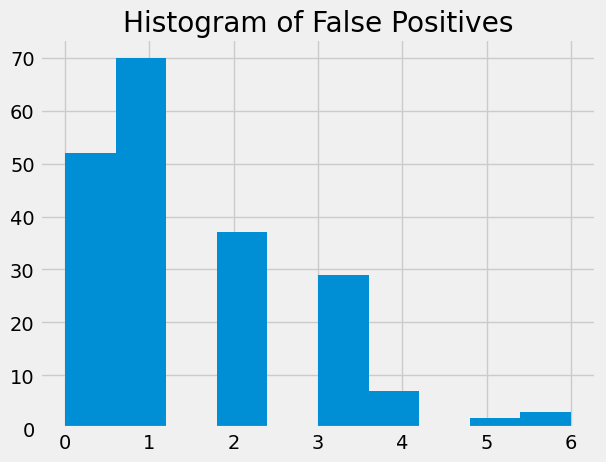

In [5]:
fig1 = plt.hist(fp)
plt.title(r'Histogram of False Positives')
plt.show()

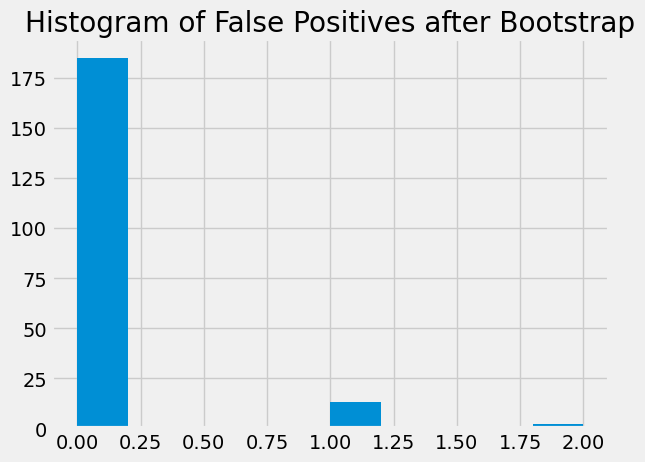

In [6]:
fig2 = plt.hist(mb_fp)
plt.title(r'Histogram of False Positives after Bootstrap')
plt.show()